In [98]:
import pandas as pd
import numpy as np

In [2]:
raw=pd.read_csv(r'C:\Users\Stas\Downloads\Copy of BASE_BN_CASH_SALE_2CONTACT_20191219.csv', sep='\t', comment='#')


C:\Users\Stas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (2,10,26,28,30,47,49,52,54,65,66,67,68,110,114,167,170,173,176,179,185,201,203,205,207,246,292,323,327,434,435) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
raw.shape

(115081, 450)

In [4]:
raw.head(3)

,'TYPE_BASE','REP_CLID','REP_DATE','DateCalc','Target_30_90d','CONTACT_DAY_OF_WEEK','CONTACT_HOUR','FL_4P','P24_DATREG','P24_LEDATE',...,'QTY_CALL_BN_NO_3M','QTY_CALL_BN_NO_1M','QTY_CALL_BN_ALL_3M','QTY_CALL_BN_ALL_1M','PRC_CALL_BN_OK_TO_ALL_3M','PRC_CALL_BN_OK_TO_ALL_1M','QTY_AFTER_CALL_BN_OK_3M','QTY_AFTER_CALL_BN_OK_1M','QTY_AFTER_CALL_OC_NF_O2_3M','QTY_AFTER_CALL_OC_NF_O2_1M'
0,'train',22181,'2019-01-26','2019-01-01',0.0,7.0,16.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,'train',22181,NaN,'2019-12-01',NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,'train',22182,NaN,'2019-12-01',NaN,NaN,NaN,'N','2011-09-19','2019-10-17',...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Remove unnecessary symbols
raw.columns = raw.columns.str.replace("['']", "")
raw=raw.replace(',','.', regex=True)
raw=raw.replace("'",'', regex=True)

In [6]:
# Finding columns, whose strings can be converted to numerical format and converting them:
raw=raw.apply(pd.to_numeric, errors='ignore')

In [7]:
dates=raw.filter(regex='DATA|DAT|Date').columns

In [8]:
#Convirting all dates into datetime format, so that they can be used in calculations:
raw[['REP_DATE', 'DateCalc', 'P24_DATREG', 'P24_LEDATE', 'DATE_LAST_PHOTO',
       'DATE_FIRST_KDV_CEL', 'DATE_FIRST_KDV_WITHOUT_CEL', 'FIRST_PROD_DATE',
       'MIN_DATESTART_ALL_CRCARDS', 'MIN_DATEFIRST_DB_CRCARDS',
       'DATE_PENS_DOC']]=raw[['REP_DATE', 'DateCalc', 'P24_DATREG', 'P24_LEDATE', 'DATE_LAST_PHOTO',
       'DATE_FIRST_KDV_CEL', 'DATE_FIRST_KDV_WITHOUT_CEL', 'FIRST_PROD_DATE',
       'MIN_DATESTART_ALL_CRCARDS', 'MIN_DATEFIRST_DB_CRCARDS',
       'DATE_PENS_DOC']].apply(pd.to_datetime)

In [9]:
raw=raw.sort_values(by='REP_DATE')


###### Separating dataframe to train and test sets

In [10]:
test=raw.loc[(raw.REP_DATE >='2019-08-01') & (raw.REP_DATE <='2019-08-31')] 


In [11]:
indexNames = raw[ (raw.REP_DATE >='2019-08-01') & (raw.REP_DATE <='2019-08-31') ].index
train= raw.drop(indexNames)
train.shape

(103407, 450)

In [12]:
test.shape

(11674, 450)

# Data visualization.  Change of client responses distribution depending on month in % 

In [13]:
#keeping raws, where target value is known
train= train[train['Target_30_90d'].notna()]
train.shape

(43192, 450)

In [14]:
train.Target_30_90d=train.Target_30_90d.apply(round)

In [15]:
#dropping rows with duplicated CLID
train.drop_duplicates(['REP_CLID'], keep='last', inplace=True)

In [16]:
#Creating response month column for data visualization and analysis:
train['REP_MONTH'] = train['REP_DATE'].dt.strftime('%b')

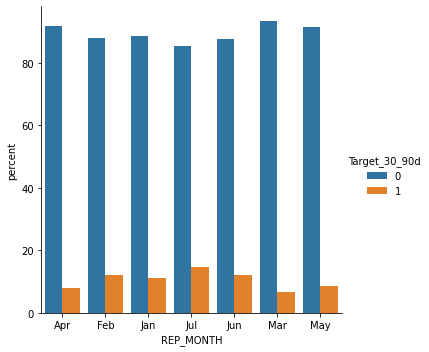

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
x,y = 'REP_MONTH', 'Target_30_90d'

(train
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'))

Percentage of clients with positive answers about taking a loan does not change drastically along all months. March has the lowest rate of positive answers. July is an outperforming month. 

# Train data preprocessing 

# 1. Feature selection

## 1.1 Handling missing values

#### Defining columns with high % of missing values. Researching them with the purpose o fulfilling or dropping

In [18]:
#Defining features, having more than 40% of MV
missing=(train.isna().sum()/len(train)).sort_values(ascending=False).to_frame().reset_index()
missing.columns.values[1] = "rate"
missing=missing.loc[missing.rate >0.4]
#Number of columns to fulfill or drop:
len(missing)

77

In [19]:
# Researching columns with high MV %. Defining, what can be calculated further:
missing.head(5)

,index,rate
0,RAZN_COUN_REF_UBKI,1.0
1,P24_WEB_ENTRY_1M,1.0
2,P24_WEB_ENTRY_QTY,1.0
3,P24_WEB_ENTRY_6M,1.0
4,P24_WEB_DAY_6M,1.0


###### What can be calculated as the research shows:

In [20]:
# Counting A24-Tenure and days after the recent A24 entry
train['P24_WEB_REG']= (train.REP_DATE - train.P24_DATREG).dt.days
train['P24_WEB_ENTRY_QTY']=(train.REP_DATE - train.P24_LEDATE).dt.days

#### Dropping columns with high percentage of missing values:

In [21]:
# We set threshold of MV of 60% 
selected=train.dropna(axis=1,thresh=0.6*len(train))

In [22]:
selected.head(2)

,TYPE_BASE,REP_CLID,REP_DATE,DateCalc,Target_30_90d,CONTACT_DAY_OF_WEEK,CONTACT_HOUR,FL_4P,P24_DATREG,P24_LEDATE,...,QTY_CALL_BACK_MONTH,QTY_QUERY_KI_1M_3M_UBKI,QTY_QUERY_KI_1M_6M_UBKI,QTY_QUERY_KI_1M_12M_UBKI,QTY_QUERY_KI_ALL_UBKI,QTY_QUERY_KI_1M_3M_UBKI_TEK,QTY_QUERY_KI_1M_6M_UBKI_TEK,QTY_QUERY_KI_1M_12M_UBKI_TEK,QTY_QUERY_KI_ALL_UBKI_TEK,REP_MONTH
32400,train,34251,2019-01-02,2018-12-01,0,4.0,19.0,N,2016-08-10,2018-10-12,...,0.0,0.0,0.0,0.0,7.0,1.0,2.0,3.0,7.0,Jan
32274,train,34206,2019-01-02,2018-12-01,0,4.0,19.0,N,2013-10-10,2018-11-09,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,Jan


###### Dropping further, obviously not needed for classification columns

In [23]:

dates=selected.filter(regex='DATA|DAT|Date').columns
dates

Index(['REP_DATE', 'DateCalc', 'P24_DATREG', 'P24_LEDATE', 'DATE_LAST_PHOTO',
       'FIRST_PROD_DATE', 'MIN_DATESTART_ALL_CRCARDS',
       'MIN_DATEFIRST_DB_CRCARDS', 'QTY_M_P24_LEDATE', 'QTY_D_P24_LEDATE'],
      dtype='object')

In [24]:
selected.drop(['REP_DATE', 'DateCalc', 'P24_DATREG', 'P24_LEDATE', 'DATE_LAST_PHOTO',
       'FIRST_PROD_DATE', 'MIN_DATESTART_ALL_CRCARDS', 'QTY_M_P24_LEDATE', 'QTY_D_P24_LEDATE', 'REP_MONTH','MIN_DATEFIRST_DB_CRCARDS'],axis=1, inplace=True)
selected.shape

C:\Users\Stas\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(35994, 364)

## 1.2 Dropping columns that reflect the same things:

In [25]:
import numpy as np
corr_matrix = selected.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column]>= 0.95)]
selected.drop(to_drop, axis=1, inplace=True)
selected.shape

(35994, 341)

# 1.3 Researching the rest columns with MV for fulfilling them

In [26]:
#Researching features left
missing2=(selected.isna().sum()/len(selected)).sort_values(ascending=False).to_frame().reset_index()
missing2.columns.values[1] = "rate"
missing2[20:30]

,index,rate
20,CL_CCY_DOP,0.218425
21,CL_CCY_ZP,0.216203
22,AVG_AMT_DB_TARG_MONTH,0.210924
23,CL_EDU,0.208590
24,REP_LIMIT_CR,0.188781
25,CL_OFF_POS,0.166278
26,RAT_DBATM_TO_DBALL_6M,0.157498
27,RAT_DBOTHER_TO_DBALL_6M,0.157498
28,RAT_DBSALE_TO_DBALL_6M,0.157360
29,FL_ADDR_JUR_IS_ADDR_FACT,0.149164


In [27]:
# these ones don't bring any value for classification:
selected.drop(['ADDR_ZIP', 'CL_INDUSTR', 'CL_OWN_TYPE', 'REP_CLID','MOB_PHN_OPER','REP_CLID','MOB_PHN_OPER'], axis=1, inplace=True)

C:\Users\Stas\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [28]:
#Fulfilling Nans in numeric columns
cols = selected.dtypes.pipe(lambda x: x[x == 'float64']).index
for c in cols:
    selected[c] = selected[c].fillna(selected[c].mean())

C:\Users\Stas\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [29]:
#Filling MVs in categorical columns with the most frequent value in the column:
cols2 = selected.dtypes.pipe(lambda x: x[x == 'object']).index
for c in cols2:
    selected[c] = selected[c].fillna(selected[c].value_counts().index[0])

C:\Users\Stas\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [30]:
selected.shape

(35994, 336)

## 1.4 Dropping columns with constant values along all rows

In [31]:
selected=selected.loc[:,selected.apply(pd.Series.nunique) != 1]
selected.shape

(35994, 310)

## 1.5 Research ourliers in categorical columns. Check if they are absent in test df

In [32]:
obj=selected.select_dtypes(include=['object'])
obj=obj.loc[:, obj.apply(lambda x: x.nunique()) < 5]

In [33]:
for col in obj:
    print(obj[col].value_counts())

N    31153
Y     4841
Name: FL_4P, dtype: int64
N    35668
Y      326
Name: FL_REL_LINK, dtype: int64
N    35934
Y       60
Name: FL_EMPLOYEE, dtype: int64
Y    35904
N       90
Name: FL_ACTIVE, dtype: int64
N    35986
Y        8
Name: FL_SB_ENGINE, dtype: int64
N    35975
Y       19
Name: FL_NO_UA, dtype: int64
ГОРОД         28386
ПГТ            3828
СЕЛО           3780
Name: RESIDENCE_CITY_TYPE, dtype: int64
N    34731
Y     1263
Name: FL_DEFAULT_1, dtype: int64
N    35746
Y      248
Name: FL_DEFAULT_2, dtype: int64
N    35897
Y       97
Name: FL_DEFAULT_3, dtype: int64
N    35107
Y      887
Name: FL_FRNG_PASSP_ACTUAL, dtype: int64
F    18437
M    17557
Name: REP_SEX, dtype: int64
N    35993
Y        1
Name: REP_FL_BELIEVE, dtype: int64
UA      35993
MD          1
Name: REP_RES, dtype: int64
Y    22443
N    13551
Name: FL_RASR, dtype: int64
Y    35920
N       74
Name: FL_G_MPH, dtype: int64
N    35079
Y      915
Name: FL_Y_MPH, dtype: int64
N    29373
Y     6621
Name: FL_G_MAIL, dtyp

In [34]:
test.REP_RES.value_counts()

UA      11674
Name: REP_RES, dtype: int64

In [35]:
selected.drop(['REP_FL_BELIEVE', 'REP_RES', 'FL_SALARY_AMT_CURR_MONTH', 'CL_CCY_ZP', 'CL_CCY_DOP'], axis=1, inplace=True)

In [36]:
selected.shape

(35994, 305)

## 1.6 Encoding categorical columns 

Note: OneHotEncoding on categoricals gives worse model accuracies in our case

In [37]:
cols = selected.dtypes.pipe(lambda x: x[x == 'object']).index
for c in cols:
    selected[c] = pd.factorize(selected[c])[0]

In [38]:
train_data=selected

# 2. Scaling data and bringing them in form of numpy array

In [39]:
from sklearn import preprocessing
X_train=train_data.drop('Target_30_90d', axis=1)
X_train=preprocessing.StandardScaler().fit(X_train).transform(X_train)
y_train=train_data.Target_30_90d.values

In [40]:
y_train

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

## 3 Algorithmic feature selection

## 3.1 Feature selection with Kbest

In [41]:
import sklearn.feature_selection
select=sklearn.feature_selection.SelectKBest(k=40)
selectes_feat=select.fit(X_train, y_train)
indeces_selected=selectes_feat.get_support(indices=True)
kbest_selected_col=[train_data.columns[i] for i in indeces_selected]

train_kbest=train_data[train_data.columns[train_data.columns.isin(kbest_selected_col)]]
X_train_kbest=preprocessing.StandardScaler().fit(train_kbest).transform(train_kbest)
X_train_kbest.shape


(35994, 40)

## 3.2 Feature Selection with DecisionTree Classifier

In [42]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor().fit(X_train, y_train)


In [43]:
data=train_data.drop('Target_30_90d', axis=1)

In [44]:
feats = {} 
for feature, importance in zip(data.columns, tree.feature_importances_):
    feats[feature] = importance 

In [45]:
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})

In [46]:
importances=importances.sort_values(by='Importance', ascending=False)

In [47]:
best_features_dtree=importances.head(40).index.tolist()

Text(0.5, 1.0, 'Feature Importance')

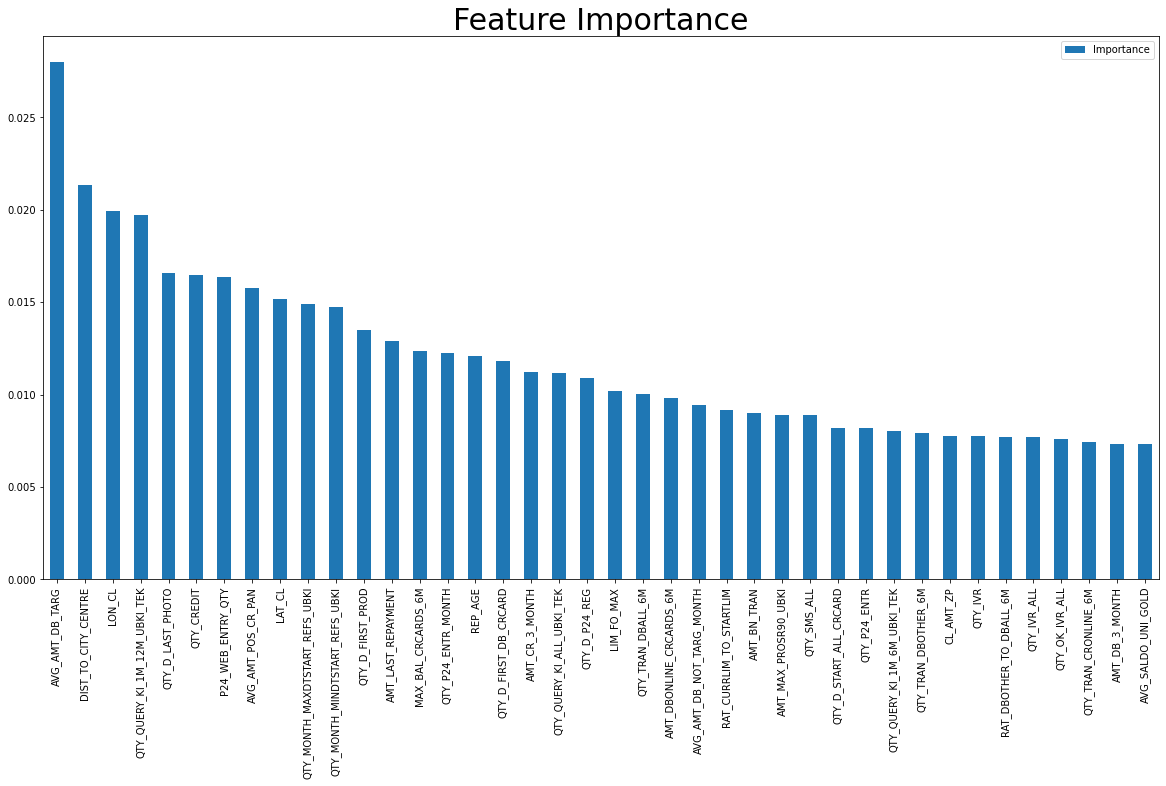

In [96]:
fig, ax = plt.subplots(figsize=(20, 10))
importances.head(40).plot(kind='bar', ax=ax)
ax.set_title('Feature Importance', fontsize=30)

In [49]:
train_dtree=train_data[train_data.columns[train_data.columns.isin(best_features_dtree)]]


In [50]:
X_train_dtree=preprocessing.StandardScaler().fit(train_dtree).transform(train_dtree)

In [51]:
X_train_dtree.shape

(35994, 40)

###### Preparing test set:

In [52]:
test_data_Kbest =test[test.columns[test.columns.isin(kbest_selected_col)]]
test_data_dtree =test[test.columns[test.columns.isin(best_features_dtree)]]

In [53]:
test_data_dtree.shape

(11674, 40)

In [54]:
test_data_Kbest.shape

(11674, 40)

In [55]:
test_data_Kbest['P24_WEB_ENTRY_QTY']=(test.REP_DATE - test.P24_LEDATE).dt.days
test_data_dtree['P24_WEB_ENTRY_QTY']=(test.REP_DATE - test.P24_LEDATE).dt.days

C:\Users\Stas\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Stas\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [56]:
# fulfilling MV in numerical columns with mea values
cols1 = test_data_Kbest.dtypes.pipe(lambda x: x[x == 'float64']).index
for c in cols1:
    test_data_Kbest[c] = test_data_Kbest[c].fillna(test_data_Kbest[c].mean())
cols2 = test_data_dtree.dtypes.pipe(lambda x: x[x == 'float64']).index
for c in cols2:
    test_data_dtree[c] = test_data_dtree[c].fillna(test_data_dtree[c].mean())

C:\Users\Stas\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Stas\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [57]:
#fulfill MV in object data
cols1 = test_data_Kbest.dtypes.pipe(lambda x: x[x == 'object']).index
for c in cols1:
    test_data_Kbest[c] = test_data_Kbest[c].fillna(test_data_Kbest[c].value_counts().index[0])
cols2 = test_data_dtree.dtypes.pipe(lambda x: x[x == 'object']).index
for c in cols2:
    test_data_dtree[c] = test_data_dtree[c].fillna(test_data_dtree[c].value_counts().index[0])
    


C:\Users\Stas\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [58]:
#Factorizing

In [59]:
cols1 = test_data_Kbest.dtypes.pipe(lambda x: x[x == 'object']).index
for c in cols1:
    test_data_Kbest[c] = pd.factorize(test_data_Kbest[c])[0]
cols2 = test_data_dtree.dtypes.pipe(lambda x: x[x == 'object']).index
for c in cols2:
    test_data_dtree[c] = pd.factorize(test_data_dtree[c])[0]

C:\Users\Stas\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [60]:

X_test_dtree=preprocessing.StandardScaler().fit(test_data_dtree).transform(test_data_dtree)
X_test_Kbest=preprocessing.StandardScaler().fit(test_data_Kbest).transform(test_data_Kbest)
y_test= test.Target_30_90d.values

In [61]:
print(X_test_dtree.shape)
print(X_test_Kbest.shape)

(11674, 40)
(11674, 40)


In [62]:
y_test.shape

(11674,)

# Building Models

### 1. Logistic Regression

In [63]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=0.01,solver='liblinear')

In [64]:
Kbestlr=logreg.fit(X_train_kbest,y_train)
Dtreelr=logreg.fit(X_train_dtree,y_train)

In [65]:
y_pred_lr_Kbest = Kbestlr.predict(X_test_Kbest)
y_pred_lr_Dtree = Dtreelr.predict(X_test_dtree)

In [66]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score

In [67]:
print ('accuracy_score with Kbest selector is:',accuracy_score(y_test,y_pred_lr_Kbest) )
print ('accuracy_score with decision tree classifier is:',accuracy_score(y_test,y_pred_lr_Dtree ))

accuracy_score with Kbest selector is: 0.8740791502484153
accuracy_score with decision tree classifier is: 0.874935754668494


So further we will use features, selected by dec tree classifier

In [68]:
X_train=X_train_dtree
X_test= X_test_dtree

In [69]:
logreg=logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)
accuracy_score(y_test,y_pred_lr)

0.874935754668494

###### Finding model parameters 

In [70]:
from sklearn.model_selection import GridSearchCV

In [71]:
grid = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}

In [72]:
%%time
CV_lr = GridSearchCV(logreg, param_grid = grid, scoring = 'recall')
CV_lr.fit(X_train, y_train)
print (CV_lr.best_params_)

{'C': 0.1, 'penalty': 'l2'}
Wall time: 46.2 s


In [73]:
logreg2= LogisticRegression(C=0.001,solver='liblinear', penalty = 'l2')
logreg_best=logreg2.fit(X_train, y_train)
y_pred_lr_best = logreg_best.predict(X_test)
accuracy_score(y_test,y_pred_lr_best)

0.8751070755525099

## Random Forest

In [74]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train, y_train)
y_pred_rf=rf.predict(X_test)

In [75]:
accuracy_score(y_test,y_pred_rf)

0.8781908514647936

###### Tuning model parameters 

In [76]:
print(rf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [77]:
%%time
param_grid = { 
'n_estimators': [200,300,400,500,700],
'max_features': ['auto', 'sqrt', 'log2'],
'max_depth': [5, 8, 15, 25, 30],
}

CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=4, cv= 5)
CV_rfc.fit(X_train, y_train)
print (CV_rfc.best_params_) 

{'max_depth': 25, 'max_features': 'log2', 'n_estimators': 700}
Wall time: 2h 13min 20s


In [78]:
rf_best = RandomForestClassifier(max_features='log2', n_estimators=700, max_depth=5)
rf_best.fit(X_train, y_train)
y_pred_rf_best=rf_best.predict(X_test)

In [79]:
accuracy_score(y_test,y_pred_rf_best)

0.8759636799725886

In [80]:
accuracy_score(y_test,y_pred_rf)

0.8781908514647936

## SVM

In [81]:
from sklearn import svm

svmmodel = svm.SVC(kernel='rbf', probability=True)
svmmodel.fit(X_train, y_train) 

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [82]:
y_pred_svm=svmmodel.predict(X_test)
accuracy_score(y_test,y_pred_svm)

0.8763063217406202

In [97]:
#Grid search
# svmmodel=svm.SVC()
# parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
#                 'C': [1, 10, 100, 1000]},
#               {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

# CV_svm= GridSearchCV(svmmodel, parameters)
# CV_svm.fit(X_train, y_train)
# print (CV_rfc.best_params_)

###### KNN

In [83]:
from sklearn.neighbors import KNeighborsClassifier

Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMtx=[];
for n in range(1,Ks):
    neigh = KNeighborsClassifier(n_neighbors=n).fit(X_train, y_train)
    ypred = neigh.predict(X_test)
    mean_acc[n-1] =accuracy_score(y_test, ypred)
    std_acc[n-1] = np.std(ypred==y_test)/np.sqrt(ypred.shape[0])
mean_acc

array([0.82508138, 0.8711667 , 0.86439952, 0.87476443, 0.871595  ,
       0.87579236, 0.87416481, 0.87587802, 0.87502142])

###### Finding best model parameters 

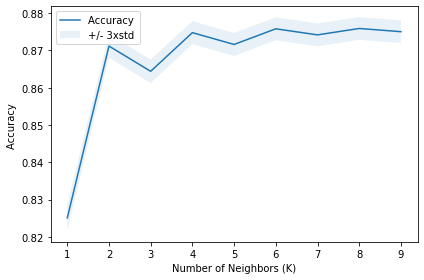

The best accuracy was with 0.8758780195305808 with k= 8


In [84]:
plt.plot(range(1,Ks),mean_acc)
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

neigh = KNeighborsClassifier(n_neighbors=mean_acc.argmax()+1).fit(X_train, y_train)

In [85]:
kneigh = KNeighborsClassifier(n_neighbors=8).fit(X_train, y_train)

In [86]:
y_pred_knn=kneigh.predict(X_test)

In [87]:
print ('Accuracy Score of knn:',accuracy_score(y_test, y_pred_knn) )

Accuracy Score of knn: 0.8758780195305808


###### Summary of grid search for the models listed:

Grid parameters give worse accuracy in the Random Forest model and result in a slight improvement in the logistic regression model.

#  Comparative evaluation of the models

In [103]:
as1=accuracy_score(y_test, y_pred_lr_best)
fs1=f1_score(y_test, y_pred_lr_best, average='weighted')  
ps1=precision_score(y_test, y_pred_lr_best)

as2=accuracy_score(y_test, y_pred_rf)
fs2=f1_score(y_test, y_pred_rf, average='weighted')  
ps2=precision_score(y_test, y_pred_rf)

as3=accuracy_score(y_test, y_pred_svm)
fs3=f1_score(y_test, y_pred_svm, average='weighted')  
ps3=precision_score(y_test, y_pred_svm)

as4=accuracy_score(y_test, y_pred_knn)
fs4=f1_score(y_test, y_pred_knn, average='weighted')  
ps4=precision_score(y_test, y_pred_knn)

list_as = [as1, as2, as3, as4]
list_fs = [fs1, fs2, fs3, fs4]
list_ps = [ps1, ps2, ps3, ps4]

In [104]:
results = pd.DataFrame(list_as, index=['Logistic Regression', 'Random Forest', 'SVM', 'KNN'])
results.columns = ['Accuracy score']
results.insert(loc=1, column='F1-score', value=list_fs)
results.insert(loc=2, column='Precision score', value=list_ps)
results.columns.name = 'Algorithm'
results

Algorithm,Accuracy score,F1-score,Precision score
Logistic Regression,0.875107,0.823703,0.465909
Random Forest,0.878191,0.826597,0.720588
SVM,0.876306,0.819867,0.750000
KNN,0.875878,0.821076,0.538462


In [91]:
from sklearn.metrics import roc_curve

##### ROC curve Logistic Regression

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.671


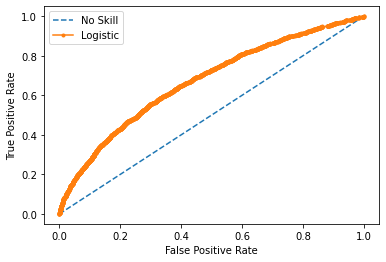

In [105]:
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = logreg2.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

##### ROC curve Random Forest

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.661


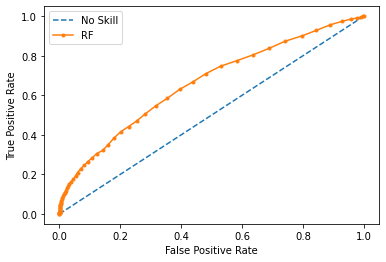

In [93]:
ns_probs = [0 for _ in range(len(y_test))]
rf_probs = rf.predict_proba(X_test)
rf_probs = rf_probs[:, 1]
ns_auc = roc_auc_score(y_test, ns_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random Forest: ROC AUC=%.3f' % (rf_auc))
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

##### ROC curve SVM

No Skill: ROC AUC=0.500
SVM: ROC AUC=0.604


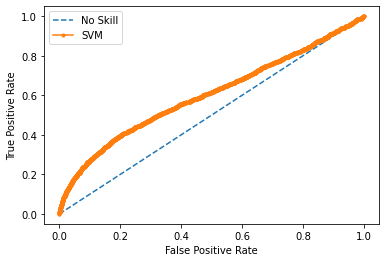

In [94]:
ns_probs = [0 for _ in range(len(y_test))]
svm_probs = svmmodel.predict_proba(X_test)
svm_probs = svm_probs[:, 1]
ns_auc = roc_auc_score(y_test, ns_probs)
svm_auc = roc_auc_score(y_test, svm_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('SVM: ROC AUC=%.3f' % (svm_auc))
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(svm_fpr, svm_tpr, marker='.', label='SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

###### ROC curve KNN

No Skill: ROC AUC=0.500
KNN: ROC AUC=0.591


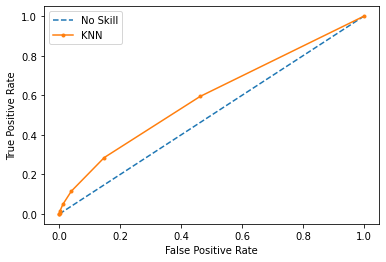

In [95]:
ns_probs = [0 for _ in range(len(y_test))]
knn_probs = kneigh.predict_proba(X_test)
knn_probs = knn_probs[:, 1]
ns_auc = roc_auc_score(y_test, ns_probs)
knn_auc = roc_auc_score(y_test, knn_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('KNN: ROC AUC=%.3f' % (knn_auc))
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(knn_fpr, knn_tpr, marker='.', label='KNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Итог 

Лучший результат достигается использованием алгоритма Random Forest. 

###### Также было проверено действие следующих шагов на улучшение качества классификации:

* удаление из выборки out- и underperforming месяцев по заявкам на кредит (март и июль)
* удаление outliers числовых данных
* использование get_dummies для кодирования категорийных данных. 
* увеличение и снижение допустимого процента NaN значений при фильтрации признаков. 60% - оптимальный критерий при удалении признаков. 

**Вышеперечисленные аспекты подготовки данных приводят к ухудшению работы алгоритмов классификации**